# Романов Дмитрий ИУ6-54Б
# ДОМАШНЕЕ ЗАДАНИЕ 4. Рекомендательные системы и Spark MLlib

### Содержание

- [Задание 1. Анализ датасета](#Задание-1.-Анализ-датасета)
- [Задание 2. Коллаборативная фильтрация](#Задание-2.-Коллаборативная-фильтрация)
- [Задание 3. Факторизация матрицы](#Задание-3.-Факторизация-матрицы)

## **Задание 1**. Анализ датасета

- **Вариант 1.** Animation, Romance, Documentary
- **Вариант 2.** Drama, Comedy, Musical
- **Вариант 3.** Thriller, Sci-Fi, Adventure

⚠️ **Замечание:** Один фильм может принадлежать разным жанрам

1. Выведите данные, сопоставляющие жанры и количество фильмов
2. Выведите первые 10 фильмов с наибольшим количеством рейтингов для каждого жанра в соответствии с вариантом
3. Выведите первые 10 фильмов с наименьшим количеством рейтингов (но больше 10) для каждого жанра в соответствии с вариантом
4. Выведите первые 10 фильмов с наибольшим средним рейтингом при количестве рейтингов больше 10 для каждого жанра в соответствии с вариантом
5. Выведите первые 10 фильмов с наименьшим средним рейтингом при количестве рейтингов больше 10 для каждого жанра в соответствии с вариантом


## **Задание 2**. Коллаборативная фильтрация

- **Вариант 1.** По схожести пользователей
- **Вариант 2.** По схожести объектов

1. Разделите данные с рейтингами на обучающее (train_init - 0.8) и тестовое подмножества (test - 0.2), определите среднее значение рейтинга в обучающем подмножестве и вычислите `rmse` для тестового подмножества, если для всех значений из test предсказывается среднее значение рейтинга
2. Реализуйте коллаборативную фильтрацию в соответствии с вариантом. Для определения схожести используйте train_init, для расчета `rmse` - test
3. Определите `rmse` для тестового подмножества

## **Задание 3**. Факторизация матрицы

1. Выберите модель `ALS` по минимальному значению `rmse`. Для этого используйте кросс-валидацию `k-folds` c k=4

    Параметры:
    - Количество факторов: `[5, 10, 15]`
    - Регуляризация: `[0.001, 0.01, 0.1, 1, 10]`

    ⚠️ **Замечание:** Если какие-то элементы из тестового/валидационного подмножества не встречались в обучающем, то `rmse` будет `NaN`

2. Сравните результаты рекомендаций посредством коллаборативной фильтрации и факторизации матрицы рейтингов


In [1]:
surname = "Романов"

alp = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [1, 42, 21, 21, 34,  6, 44, 26, 18, 44, 38, 26, 14, 43,  4, 49, 45,
        7, 42, 29,  4,  9, 36, 34, 31, 29,  5, 30,  4, 19, 28, 25, 33]

d = dict(zip(alp, w))
variant =  sum([d[el] for el in surname.lower()]) % 40 + 1

print("Задача № 1: ", variant % 3 + 1)
print("Задача № 2: ", variant % 2 + 1 )

Задача № 1:  1
Задача № 2:  2


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, count, avg, desc, asc, lit, when, expr, sqrt, row_number
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.window import Window

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MovieRecommendation") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

movies_pd = pd.read_csv("/Users/dmitryromanov/Desktop/BigData_uni/hw4/ml-latest/movies.csv")
ratings_pd = pd.read_csv("/Users/dmitryromanov/Desktop/BigData_uni/hw4/ml-latest/ratings.csv")

movies = spark.createDataFrame(movies_pd)
ratings = spark.createDataFrame(ratings_pd)

movies = movies.select(col("movieId").cast(IntegerType()), col("title"), col("genres"))
ratings = ratings.select(col("userId").cast(IntegerType()), col("movieId").cast(IntegerType()), col("rating").cast(FloatType()))

print("фильмов:", movies.count())
print("рейтингов:", ratings.count())

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 00:19:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/10 00:23:34 WARN TaskSetManager: Stage 3 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


фильмов: 86537


рейтингов: 33832162


In [4]:
target_genres = ["Animation", "Romance", "Documentary"]

movies_genres = movies.withColumn("genre", explode(split(col("genres"), "\\|"))).select("movieId", "title", "genre")
movies_sel = movies_genres.filter(col("genre").isin(target_genres))

genre_counts = movies_sel.groupBy("genre").agg(count("movieId").alias("num_movies")).orderBy(desc("num_movies"))
genre_counts.show()

+-----------+----------+
|      genre|num_movies|
+-----------+----------+
|    Romance|     10172|
|Documentary|      9283|
|  Animation|      4579|
+-----------+----------+



Количество фильмов по жанрам

In [5]:
ratings_stats = ratings.groupBy("movieId").agg(count("*").alias("num_ratings"), avg("rating").alias("avg_rating"))
movie_stats = movies_sel.join(ratings_stats, "movieId", "left")
movie_stats = movie_stats.fillna({"num_ratings": 0, "avg_rating": 0})

топ 10 фильмов с наибольшим количеством рейтингов

In [6]:
MIN_RATINGS_THRESHOLD = 10

window_spec = Window.partitionBy("genre").orderBy(desc("num_ratings"), desc("avg_rating"))
top10_num = movie_stats.withColumn("rnk", row_number().over(window_spec)).filter(col("rnk") <= 10)
top10_num.select("genre", "title", "num_ratings", "avg_rating").orderBy("genre", desc("num_ratings")).show(100, truncate=False)

25/12/10 00:23:38 WARN TaskSetManager: Stage 10 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


+-----------+-------------------------------------------------------+-----------+------------------+
|genre      |title                                                  |num_ratings|avg_rating        |
+-----------+-------------------------------------------------------+-----------+------------------+
|Animation  |Toy Story (1995)                                       |76813      |3.8935076093890357|
|Animation  |Shrek (2001)                                           |58529      |3.7485947137316544|
|Animation  |Aladdin (1992)                                         |55791      |3.70176193292825  |
|Animation  |Lion King, The (1994)                                  |53509      |3.8334766114111645|
|Animation  |Monsters, Inc. (2001)                                  |48441      |3.8405276521954543|
|Animation  |Finding Nemo (2003)                                    |48124      |3.820723547502286 |
|Animation  |Beauty and the Beast (1991)                            |45404      |3.67988503

топ 10 фильмов с наименьшим количеством рейтингов (>10)

In [7]:
window_spec2 = Window.partitionBy("genre").orderBy(asc("num_ratings"), asc("avg_rating"))
bottom10_num = movie_stats.filter(col("num_ratings") > MIN_RATINGS_THRESHOLD).withColumn("rnk", row_number().over(window_spec2)).filter(col("rnk") <= 10)
bottom10_num.select("genre", "title", "num_ratings", "avg_rating").orderBy("genre", asc("num_ratings")).show(100, truncate=False)

25/12/10 00:23:41 WARN TaskSetManager: Stage 18 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


+-----------+-----------------------------------------------------------------------------------------+-----------+------------------+
|genre      |title                                                                                    |num_ratings|avg_rating        |
+-----------+-----------------------------------------------------------------------------------------+-----------+------------------+
|Animation  |The Swan Princess Christmas (2012)                                                       |11         |1.1363636363636365|
|Animation  |Norm of the North: Keys to the Kingdom (2018)                                            |11         |1.5909090909090908|
|Animation  |The Legend of the Titanic (1999)                                                         |11         |1.6363636363636365|
|Animation  |Puss in Book: Trapped in an Epic Tale (2017)                                             |11         |1.8181818181818181|
|Animation  |VeggieTales: The Ultimate Silly Song Count

топ 10 фильмов с наибольшим средним рейтингом (>10 рейтингов)

In [8]:
window_spec3 = Window.partitionBy("genre").orderBy(desc("avg_rating"), desc("num_ratings"))
top10_avg = movie_stats.filter(col("num_ratings") > MIN_RATINGS_THRESHOLD).withColumn("rnk", row_number().over(window_spec3)).filter(col("rnk") <= 10)
top10_avg.select("genre", "title", "num_ratings", "avg_rating").orderBy("genre", desc("avg_rating")).show(100, truncate=False)

25/12/10 00:23:45 WARN TaskSetManager: Stage 28 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


+-----------+-----------------------------------------------------------------------------+-----------+------------------+
|genre      |title                                                                        |num_ratings|avg_rating        |
+-----------+-----------------------------------------------------------------------------+-----------+------------------+
|Animation  |Over the Garden Wall (2013)                                                  |1430       |4.256993006993007 |
|Animation  |Spider-Man: Across the Spider-Verse (2023)                                   |528        |4.252840909090909 |
|Animation  |Adventure Time: Elements (2017)                                              |12         |4.25              |
|Animation  |Spirited Away (Sen to Chihiro no kamikakushi) (2001)                         |35375      |4.226035335689046 |
|Animation  |Violet Evergarden: The Movie (2020)                                          |25         |4.22              |
|Animation  |It'

топ 10 фильмов с наименьшим средним рейтингом (>10 рейтингов)

In [9]:
window_spec4 = Window.partitionBy("genre").orderBy(asc("avg_rating"), asc("num_ratings"))
bottom10_avg = movie_stats.filter(col("num_ratings") > MIN_RATINGS_THRESHOLD).withColumn("rnk", row_number().over(window_spec4)).filter(col("rnk") <= 10)
bottom10_avg.select("genre", "title", "num_ratings", "avg_rating").orderBy("genre", asc("avg_rating")).show(100, truncate=False)

25/12/10 00:23:49 WARN TaskSetManager: Stage 37 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


+-----------+--------------------------------------------------------+-----------+------------------+
|genre      |title                                                   |num_ratings|avg_rating        |
+-----------+--------------------------------------------------------+-----------+------------------+
|Animation  |Foodfight! (2012)                                       |46         |0.9456521739130435|
|Animation  |The Swan Princess Christmas (2012)                      |11         |1.1363636363636365|
|Animation  |The Amazing Bulk (2012)                                 |15         |1.1666666666666667|
|Animation  |Barbie & Her Sisters in the Great Puppy Adventure (2015)|78         |1.1923076923076923|
|Animation  |Norm of the North (2016)                                |58         |1.5086206896551724|
|Animation  |Pokémon Heroes (2003)                                   |431        |1.519721577726218 |
|Animation  |Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (2002)     |614        |

Распределение рейтингов по жанрам

25/12/10 00:23:53 WARN TaskSetManager: Stage 46 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


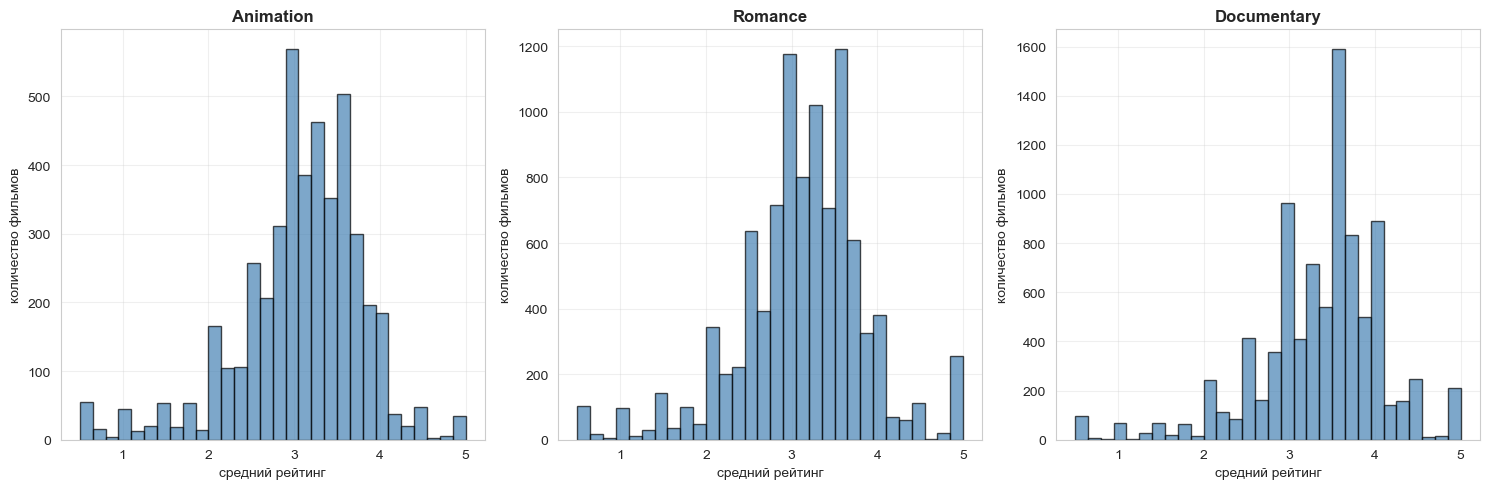

In [10]:
ratings_by_genre = movie_stats.select("genre", "avg_rating").filter(col("avg_rating") > 0).toPandas()

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, genre in enumerate(target_genres):
    data = ratings_by_genre[ratings_by_genre['genre'] == genre]['avg_rating']
    axes[idx].hist(data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{genre}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('средний рейтинг')
    axes[idx].set_ylabel('количество фильмов')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **Задание 2**. Коллаборативная фильтрация

In [11]:
train_init, test = ratings.randomSplit([0.8, 0.2], seed=42)

global_mean = train_init.agg(avg("rating")).first()[0]
print(f"средний рейтинг : {global_mean}")

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

test_pred_mean = test.withColumn("prediction", lit(global_mean))
baseline_rmse = evaluator.evaluate(test_pred_mean)
print(f"RMSE при предсказании среднего: {baseline_rmse}")

25/12/10 00:23:57 WARN TaskSetManager: Stage 51 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:24:01 WARN TaskSetManager: Stage 54 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


средний рейтинг : 3.5425100091166297


RMSE при предсказании среднего: 1.0640678952410396


In [12]:
als_item = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    rank=10,
    maxIter=10,
    regParam=0.1,
    coldStartStrategy="drop")

model_item = als_item.fit(train_init)
predictions_item = model_item.transform(test)
predictions_item = predictions_item.dropna(subset=["prediction"])
rmse_item = evaluator.evaluate(predictions_item)
print(f"RMSE для item-based CF (ALS): {rmse_item}")

25/12/10 00:24:06 WARN TaskSetManager: Stage 56 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:24:07 WARN TaskSetManager: Stage 57 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:24:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/12/10 00:24:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/12/10 00:24:30 WARN TaskSetManager: Stage 110 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


RMSE для item-based CF (ALS): 0.807134849831839


## **Задание 3**. Факторизация матрицы

In [13]:
param_grid = (ParamGridBuilder()
    .addGrid(ALS.rank, [5, 10, 15])
    .addGrid(ALS.regParam, [0.001, 0.01, 0.1, 1, 10])
    .build())

print(f"Количество комбинаций параметров: {len(param_grid)}")

als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True)

crossval = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=4,
    seed=42)

cv_model = crossval.fit(train_init)
best_model = cv_model.bestModel

best_rank = best_model._java_obj.parent().getRank()
best_reg = best_model._java_obj.parent().getRegParam()

print(f"оптимальные параметры: rank={best_rank}, regParam={best_reg}")

25/12/10 00:24:38 WARN TaskSetManager: Stage 164 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


Количество комбинаций параметров: 15


25/12/10 00:24:39 WARN TaskSetManager: Stage 165 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:24:56 WARN TaskSetManager: Stage 218 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:25:01 WARN TaskSetManager: Stage 246 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:25:05 WARN TaskSetManager: Stage 273 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:25:05 WARN TaskSetManager: Stage 274 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:25:16 WARN TaskSetManager: Stage 352 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.
25/12/10 00:25:20 WARN TaskSetManager: Stage 381 contains a task of very large size (76984 KiB). The maximum recommended task size is 10

оптимальные параметры: rank=10, regParam=0.1


In [14]:
predictions_als = best_model.transform(test)
predictions_als = predictions_als.dropna(subset=["prediction"])
rmse_als = evaluator.evaluate(predictions_als)
print(f"RMSE лучшей модели на тесте: {rmse_als}")

25/12/10 00:42:01 WARN TaskSetManager: Stage 7297 contains a task of very large size (76984 KiB). The maximum recommended task size is 1000 KiB.


RMSE лучшей модели на тесте: 0.8153126619871907


Сравнение методов rmse

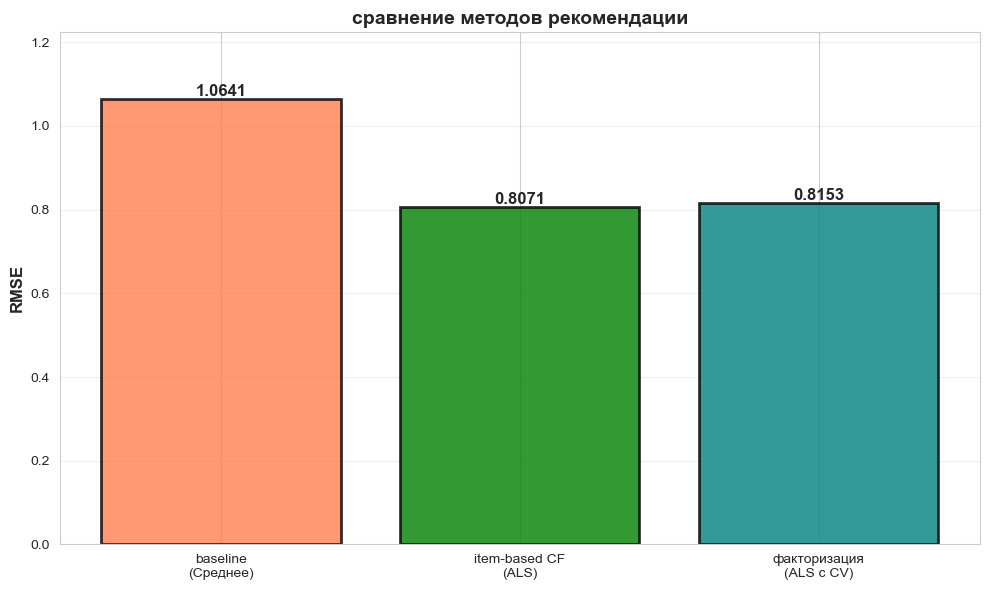

In [15]:
methods = ['baseline\n(Среднее)', 'item-based CF\n(ALS)', 'факторизация\n(ALS с CV)']
rmse_values = [baseline_rmse, rmse_item, rmse_als]
colors = ['coral','green','teal']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(methods, rmse_values, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

for bar, value in zip(bars, rmse_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax.set_title('сравнение методов рекомендации', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(rmse_values) * 1.15)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [16]:
spark.stop()